In [540]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import roc_auc_score, f1_score

# **Loading The Data**

In [541]:
HDFC=yf.download("HDFCBANK.NS", start="2016-01-01", end="2019-12-31", interval="1d")
data=HDFC.copy()

[*********************100%%**********************]  1 of 1 completed


# **Exploratory Data Analysis**


In [542]:
print(data.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-01-01  541.200012  545.125000  538.075012  544.375000  514.283264   
2016-01-04  542.000000  542.000000  534.049988  535.250000  505.662628   
2016-01-05  535.099976  537.400024  530.674988  531.200012  501.836487   
2016-01-06  528.325012  538.375000  528.325012  533.549988  504.056549   
2016-01-07  530.049988  532.450012  524.849976  528.099976  498.907898   

             Volume  
Date                 
2016-01-01  1597538  
2016-01-04  2593768  
2016-01-05  1580436  
2016-01-06  2082768  
2016-01-07  3027714  


In [543]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,982.000000,982.000000,982.000000,982.000000,982.000000,9.820000e+02
mean,887.984699,894.596027,880.952955,887.949235,853.262353,4.488815e+06
std,229.445519,231.138564,227.184856,229.007500,226.405234,7.228520e+06
min,475.000000,478.625000,464.000000,471.325012,445.271240,2.850040e+05
25%,642.125000,646.381226,638.200012,642.493729,611.960068,2.199194e+06
50%,929.362518,934.500000,922.712494,928.737518,890.478455,3.306258e+06
75%,1058.631287,1067.012512,1051.318726,1059.118744,1021.974701,5.322874e+06
max,1305.000000,1305.500000,1288.800049,1302.400024,1267.349243,2.011300e+08


In [544]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [545]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 982 entries, 2016-01-01 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       982 non-null    float64
 1   High       982 non-null    float64
 2   Low        982 non-null    float64
 3   Close      982 non-null    float64
 4   Adj Close  982 non-null    float64
 5   Volume     982 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 53.7 KB


We have 982 observations and there is no Null values in the dataframe. The index is of the type Datetime. All the features are of numerical type.

# **Plots and Description**

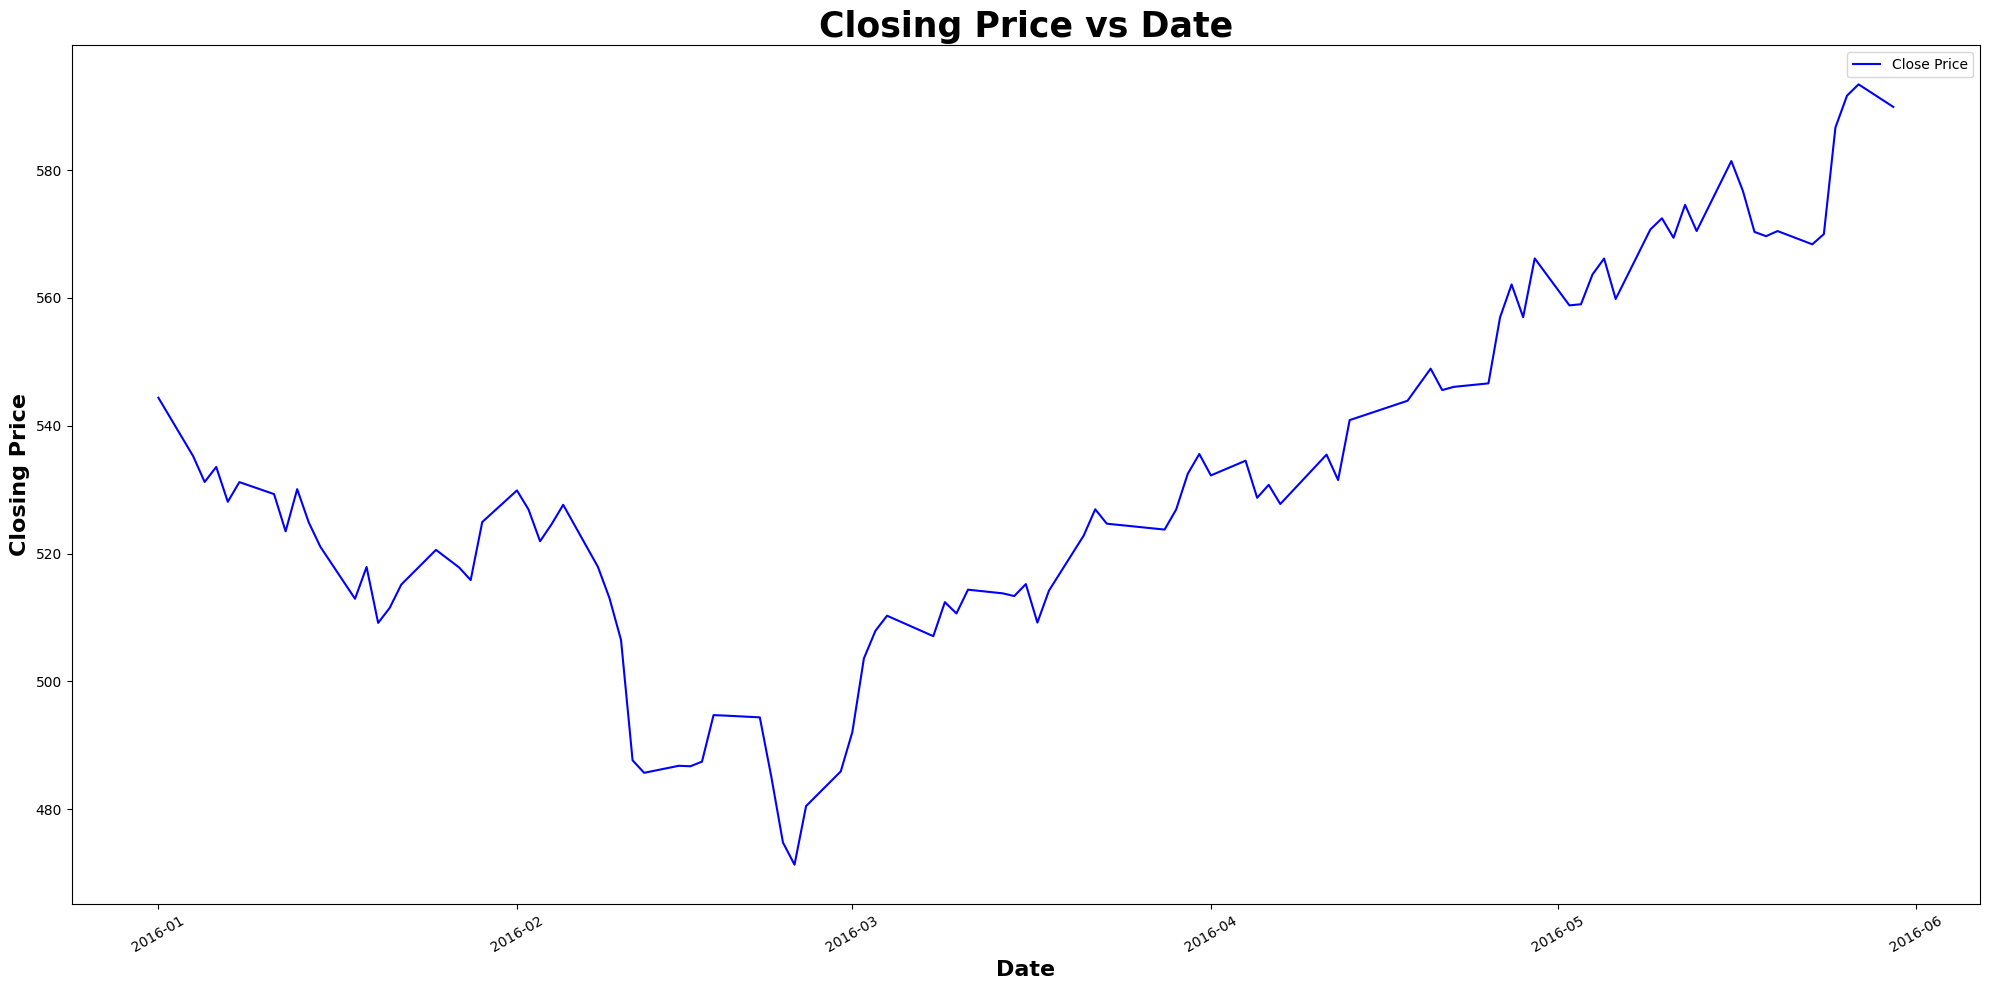

In [546]:
plt.figure(figsize=(20,10))
plt.plot(data["Close"][:100], color="blue",  label="Close Price")
plt.xlabel("Date", fontweight="bold", fontsize=16, fontfamily="sans-serif")
plt.ylabel("Closing Price",fontweight="bold", fontsize=16, fontfamily="sans-serif")
plt.title("Closing Price vs Date",fontweight="bold", fontsize=25, fontfamily="sans-serif")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

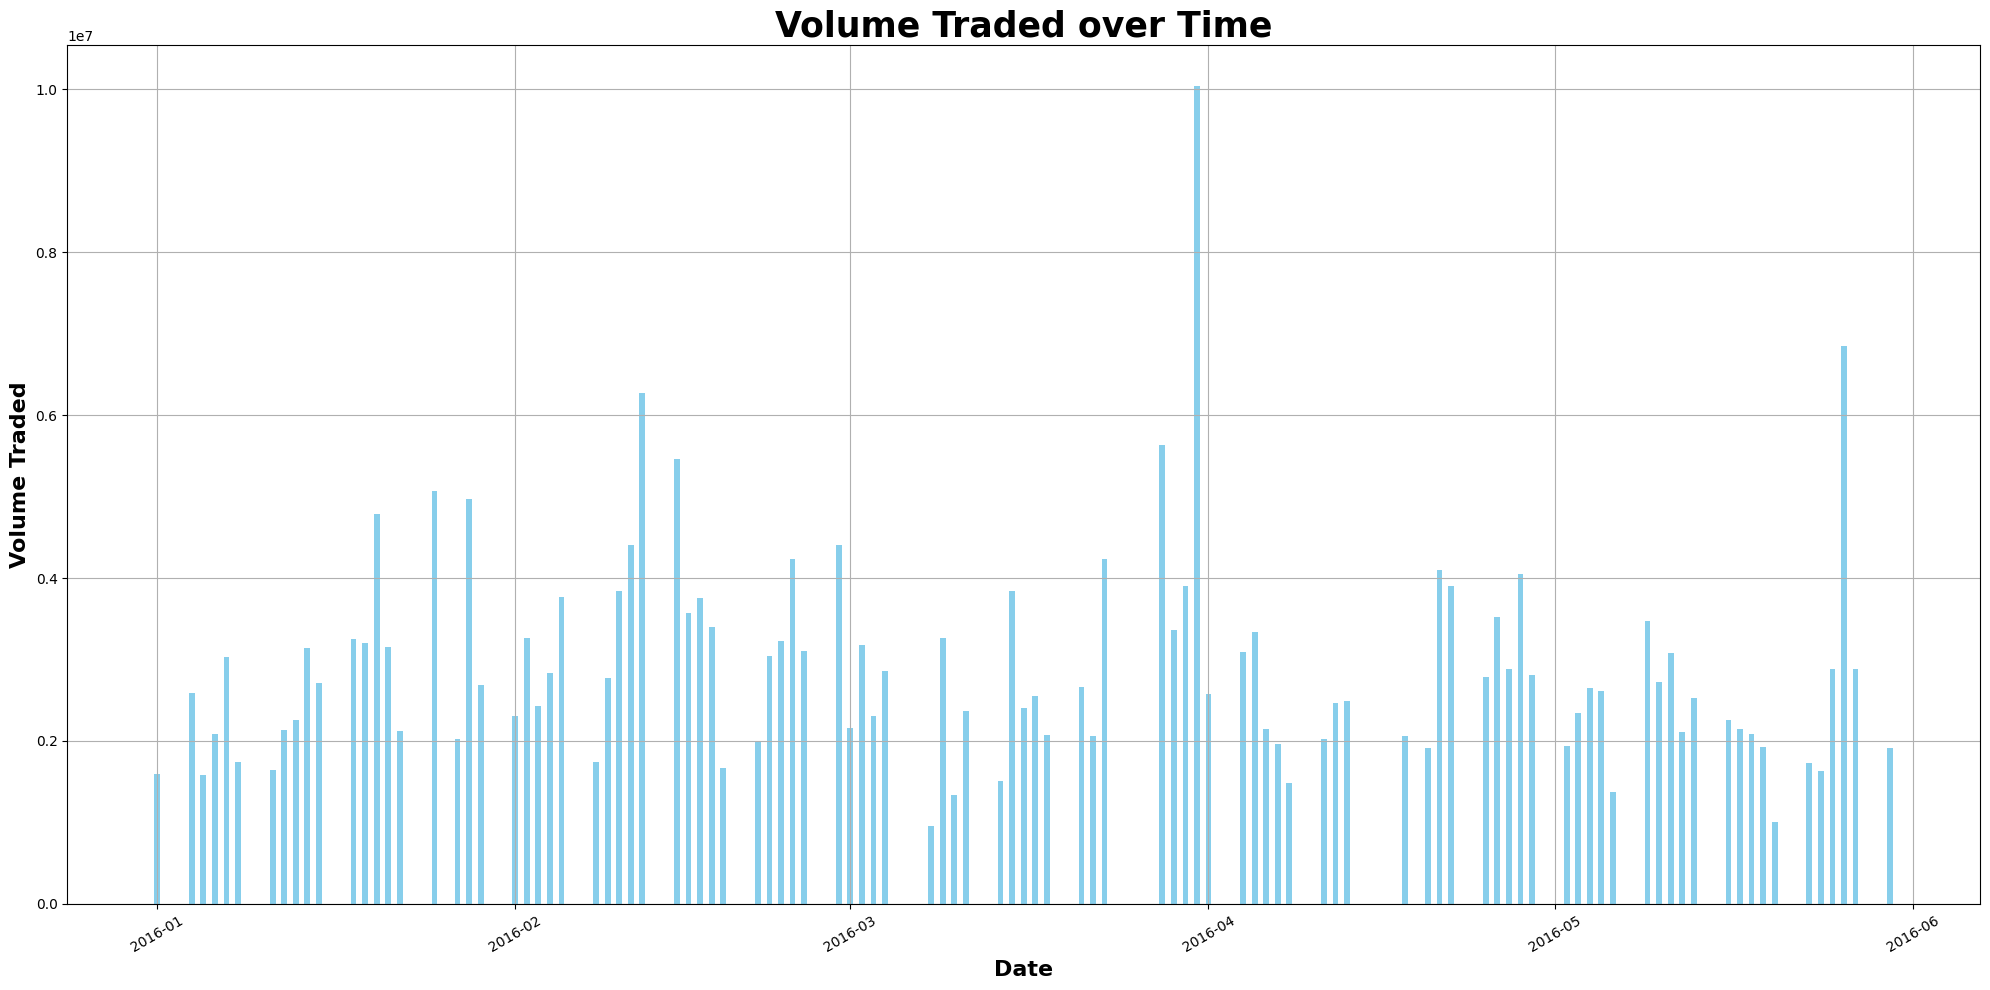

In [547]:
plt.figure(figsize=(20,10))
plt.bar(data.index[:100], data["Volume"][:100], color="skyblue", width=0.5)
plt.xlabel("Date", fontweight="bold", fontsize=16, fontfamily="sans-serif")
plt.ylabel("Volume Traded",fontweight="bold", fontsize=16,fontfamily="sans-serif")
plt.title("Volume Traded over Time",fontweight="bold", fontsize=25, fontfamily="sans-serif")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

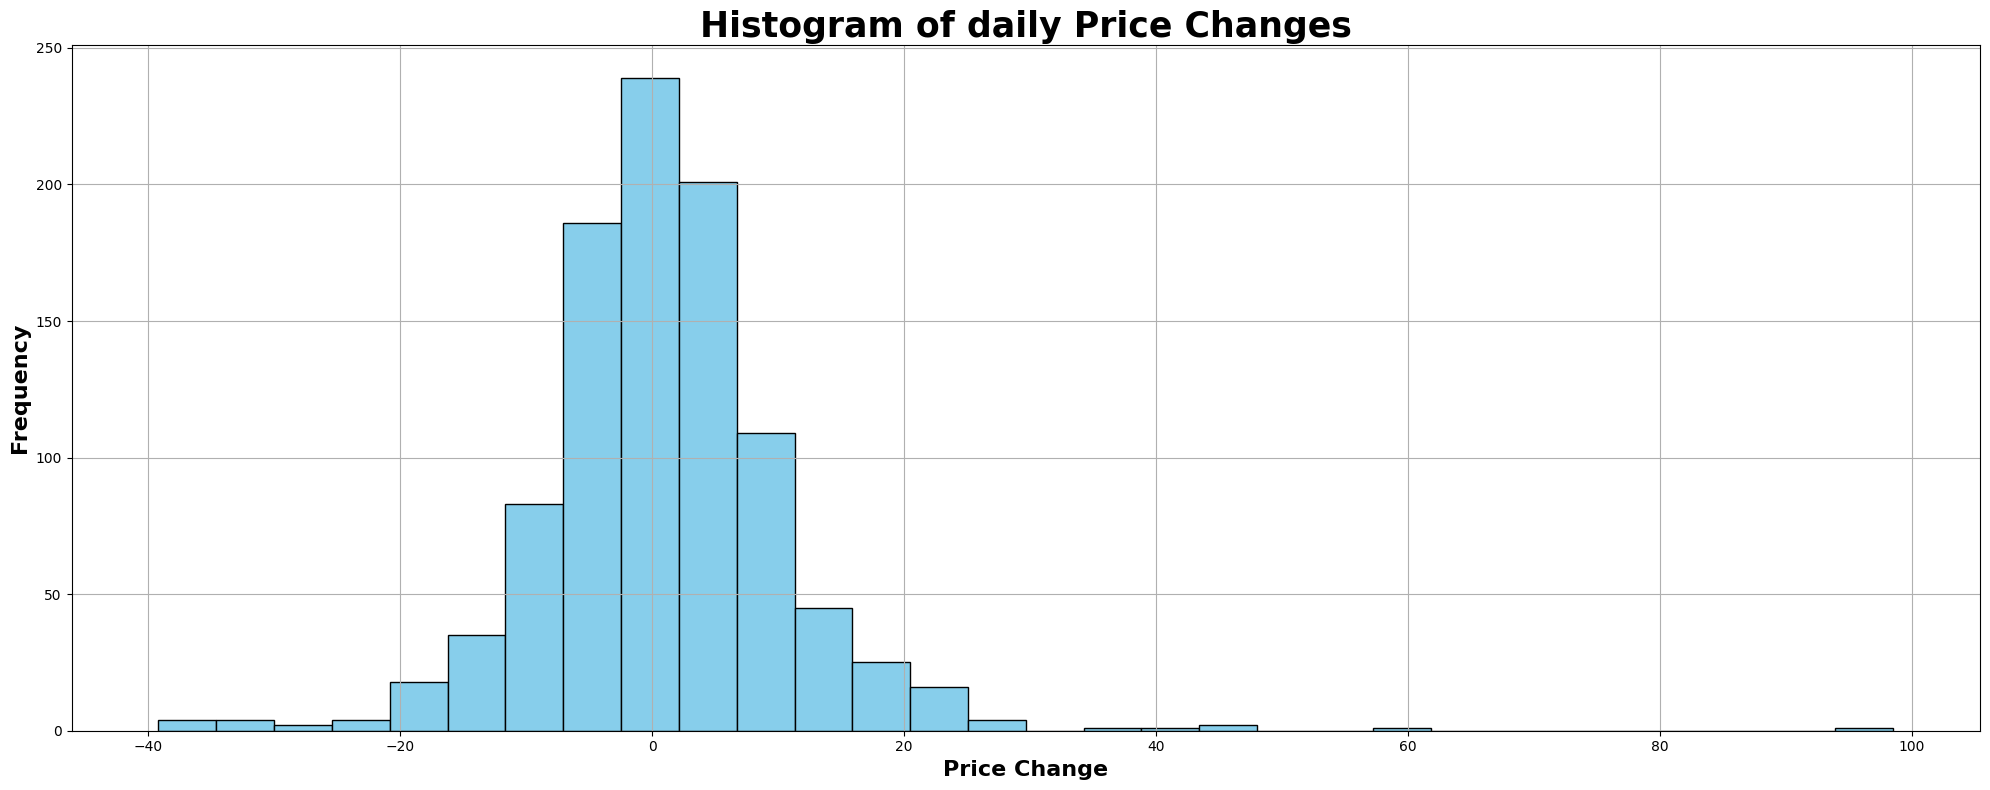

In [548]:
daily_changes=data["Close"].diff().dropna()
plt.figure(figsize=(20,8))
plt.hist(daily_changes, bins=30,color="skyblue", edgecolor="black")
plt.xlabel("Price Change", fontweight="bold", fontsize=16, fontfamily="sans-serif")
plt.ylabel("Frequency",fontweight="bold", fontsize=16,fontfamily="sans-serif")
plt.title("Histogram of daily Price Changes",fontweight="bold", fontsize=25, fontfamily="sans-serif")
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the graphs above the following points are clear with respect to the current stock in the given timeframe:


1. Trending market not a sideways market
2. Highly Liquid
3. A lot of volumes are being traded everyday
4. Not Highly Volatile




# **Function Definitons**

In [549]:
def sma_calc(prices, window):
  sma=pd.Series(index=prices.index, dtype=float)
  for i in range(len(prices)-window+1):
    sma.iloc[i+window-1]=np.mean(prices[i:(window+i)])
  return sma

In [550]:
def ema_calc(prices,window):
  ema=pd.Series(index=prices.index, dtype=float)
  initial_mean=np.mean(prices[:window])
  ema.iloc[window-1]=initial_mean
  multiplier=(2/(window+1))
  for i in range(window, len(prices)):
    ema.iloc[i]=(prices.iloc[i]*multiplier)+(ema.iloc[i-1]*(1-multiplier))
  return ema

In [551]:
def moving_std_calc(prices,window):
  moving_std=pd.Series(index=prices.index, dtype=float)
  for i in range(len(prices)-window+1):
    moving_std.iloc[i+window-1]=np.std(prices[i:(window+i)])
  return moving_std

In [552]:
def rsi_calc(prices, window):
  rsi=pd.Series(index=prices.index, dtype=float)
  gain=pd.Series(index=prices.index, dtype=float)
  loss=pd.Series(index=prices.index, dtype=float)
  for i in range(len(prices)):
    delta=prices[i]-prices[i-1]
    if (delta>0):
      gain.loc[prices.index[i]]=delta
      loss.loc[prices.index[i]]=0
    elif (delta<0):
      gain.loc[prices.index[i]]=0
      loss.loc[prices.index[i]]=-delta
    else:
      gain.loc[prices.index[i]]=0
      loss.loc[prices.index[i]]=0
  gain_mean=pd.Series(index=prices.index, dtype=float)
  loss_mean=pd.Series(index=prices.index, dtype=float)
  gain_mean=sma_calc(gain,window)
  loss_mean=sma_calc(loss,window)

  rs = gain_mean / loss_mean
  rsi = 100 - (100 / (1 + rs))
  return rsi


In [553]:
def macd_calc(prices):
  ema_7=ema_calc(prices,7)
  ema_14=ema_calc(prices,14)
  macd=pd.Series(index=prices.index, data=np.nan)
  macd_signal_line=pd.Series(index=prices.index, dtype=float)
  macd=ema_7-ema_14
  macd_line_temp=ema_calc(macd[14:],9)
  macd_signal_line[14:]=macd_line_temp.values
  return macd, macd_signal_line

In [554]:
def bollinger_bands_calc(prices,window):
  mid_band=sma_calc(prices,window)
  upper_band=mid_band+(2*moving_std_calc(prices,window))
  lower_band=mid_band-(2*moving_std_calc(prices,window))

  return upper_band, mid_band, lower_band

In [555]:
def ad_calc(high, low, close, open, volumes):

  ad=pd.Series(index=volumes.index, dtype=float)
  MFD=(((close-low)-(high-close))/(high-low))

  ad.iloc[0]=MFD.iloc[0]*volumes.iloc[0]

  for i in range(1,len(volumes)):
    ad.iloc[i]=ad.iloc[i-1]+MFD.iloc[i]*volumes.iloc[i]

  return ad


In [556]:
def adx_calc(high, low, close, window):
    delta_high = high.diff()
    delta_low = low.diff()

    tr = pd.Series(index=close.index, dtype=float)
    atr = pd.Series(index=close.index, dtype=float)
    plus_dm = pd.Series(index=close.index, dtype=float)
    minus_dm = pd.Series(index=close.index, dtype=float)
    smoothed_plus_dm = pd.Series(index=close.index, dtype=float)
    smoothed_minus_dm = pd.Series(index=close.index, dtype=float)
    plus_di = pd.Series(index=close.index, dtype=float)
    minus_di = pd.Series(index=close.index, dtype=float)
    dx = pd.Series(index=close.index, dtype=float)
    adx = pd.Series(index=close.index, dtype=float)

    for i in range(1, len(close)):
        tr_values = [high.iloc[i] - low.iloc[i], abs(high.iloc[i] - close.iloc[i-1]), abs(low.iloc[i] - close.iloc[i-1])]
        tr.iloc[i] = max(tr_values)

    atr = sma_calc(tr, window)

    for i in range(1, len(close)):
        plus_dm_val = delta_high.iloc[i] if delta_high.iloc[i] > delta_low.iloc[i] and delta_high.iloc[i] > 0 else 0
        minus_dm_val = delta_low.iloc[i] if delta_low.iloc[i] > delta_high.iloc[i] and delta_low.iloc[i] > 0 else 0
        plus_dm.iloc[i] = plus_dm_val
        minus_dm.iloc[i] = minus_dm_val

    smoothed_plus_dm = sma_calc(plus_dm, window)
    smoothed_minus_dm = sma_calc(minus_dm, window)

    plus_di = 100 * (smoothed_plus_dm / atr)
    minus_di = 100 * (smoothed_minus_dm / atr)

    dx = 100 * abs((plus_di - minus_di) / (plus_di + minus_di))
    adx = sma_calc(dx, window)

    return adx, plus_di, minus_di


In [557]:
def feature_1_calc(prices):

  ema_30=ema_calc(prices,30)
  macd, signal_line=macd_calc(prices)
  feature_1=pd.Series(index=prices.index, dtype=float)

  price_ema_diff=prices-ema_30
  macd_signal_diff=macd-signal_line

  feature_1= price_ema_diff*macd_signal_diff

  return feature_1

In [558]:
def feature_2_calc(prices, volume):

  rsi=rsi_calc(prices,14)
  rsi_scaled_down= ((rsi-50.0)/100.0)
  feature_2=volume*rsi_scaled_down

  return feature_2


**Labelling**

In [559]:
def buy_sell_prediction(prices):

  #1-Buy, 2-Hold, 0-Sell
  signals=pd.Series(index=prices.index, dtype=int)
  buy_price=0
  buy_price_stddev=0
  log_func=pd.Series(index=prices.index,dtype=float)
  std_for_buy=pd.Series(index=prices.index, dtype=float)
  log_func.iloc[0]=0

  for i in range(1,len(prices)):
    log_func.iloc[i]=np.log((prices.iloc[i])/(prices.iloc[i-1]))

  for i in range(1,len(prices)):
    std_for_buy.iloc[i]=(np.std(log_func[1:i])*math.sqrt(7))


  for i in range(1,len(prices)-2):
    if(prices.iloc[i]<prices.iloc[i+1] and prices.iloc[i+1]<prices.iloc[i+2] and buy_price==0):
      signals.iloc[i]=1
      buy_price=prices.iloc[i]
      buy_price_stddev=std_for_buy.iloc[i]*buy_price


    elif(buy_price!=0 and (((prices.iloc[i] > (buy_price+buy_price_stddev)) and (prices.iloc[i]>prices.iloc[i+1] )) or (prices.iloc[i]<=(buy_price-(buy_price_stddev/2)))) ):
      signals.iloc[i]=0
      buy_price=0

    else:
      signals.iloc[i]=2

  return signals

# **Signal Generations**

In [560]:
def generate_macd_signals(prices):

  macd, macd_line=macd_calc(prices)
  macd_signal=pd.Series(index=prices.index, dtype=int)
  for i in range(1, len(macd_signal)):
    if (macd.iloc[i] > macd_line.iloc[i] and macd.iloc[i - 1] <= macd_line.iloc[i - 1]):
        macd_signal.iloc[i] = 1
    elif (macd.iloc[i] < macd_line.iloc[i] and macd.iloc[i - 1] >= macd_line.iloc[i - 1]):
        macd_signal.iloc[i] = 0

  macd_signal.fillna(2,inplace=True)
  return macd_signal


In [561]:
def generate_ema_crossover_signals(prices, ema_fast, ema_slow):

    signals = pd.Series(index=prices.index, dtype=int)

    for i in range(len(prices)):
      if(ema_fast.iloc[i]>ema_slow.iloc[i]  and ema_fast.iloc[i-1]<=ema_slow.iloc[i-1]):
        signals.iloc[i]=1
      elif(ema_fast.iloc[i]<ema_slow.iloc[i]  and ema_fast.iloc[i-1]>=ema_slow.iloc[i-1]):
        signals.iloc[i]=0
      else:
        signals.iloc[i]=2
    return signals


In [562]:
def generate_bollinger_band_signals(data,period):

  upper, mid, lower= bollinger_bands_calc(data,20)

  bollinger_signals=pd.Series(index=data.index, dtype=int)

  for i in range (period,len(data)):
    if(data.iloc[i]>upper.iloc[i]):
      bollinger_signals.iloc[i]=0
    if(data.iloc[i]<lower.iloc[i]):
      bollinger_signals.iloc[i]=1

  bollinger_signals.fillna(2,inplace=True)

  return bollinger_signals

# **Model Function Definitons**

In [563]:
def initialize_weights(input_size, output_size):
    w = np.random.randn(input_size, output_size)*0.01
    b = np.zeros(output_size)
    return w, b

In [564]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


In [565]:
def categorical_cross_entropy_loss(y_pred, y_original):
    loss = -np.mean(np.sum(y_original*np.log(y_pred), axis=1))
    return loss

In [566]:
def forward_prop(X, w, b):
    z = np.dot(X, w) + b
    return softmax(z)

In [567]:
def backward_prop(X, output, y_true, w, b, learning_rate):
    dz = output - y_true
    m = X.shape[0]

    dw = (1 / m) * (np.dot(X.T , dz))
    db = np.mean(dz, axis=0)

    w -= learning_rate * dw
    b -= learning_rate * db
    return w, b

In [568]:
def train(x_train, y_train, epochs, learning_rate):
    input_size = x_train.shape[1]
    num_classes = y_train.shape[1]

    w, b = initialize_weights(input_size, num_classes)

    for epoch in range(epochs):
        output = forward_prop(x_train, w, b)
        loss = categorical_cross_entropy_loss(output, y_train)
        w, b = backward_prop(x_train, output, y_train, w, b, learning_rate)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    return w, b

# **Signals Plot**

In [569]:
ad=ad_calc(data["High"], data["Low"], data["Close"], data["Open"],  data["Volume"])
upper_band, mid_band, lower_band = bollinger_bands_calc(data["Close"],14)
adx, plus_di, minus_di= adx_calc(data["High"], data["Low"], data["Close"], 14)
macd, macd_line=macd_calc(data["Close"])
rsi= rsi_calc(data["Close"], 14)
ema_fast=ema_calc(data["Close"], 7)
ema_slow=ema_calc(data["Close"], 14)
feature_1=feature_1_calc(data["Close"])
feature_2=feature_2_calc(data["Close"], data["Volume"])

**MACD Signals Plot**

In [570]:
macd_signal=generate_macd_signals(data["Close"])

In [571]:
#Splitting for graph plotting purpose
df=data[200:350]
mac_sig=macd_signal[200:350]
mac=macd[200:350]
line=macd_line[200:350]

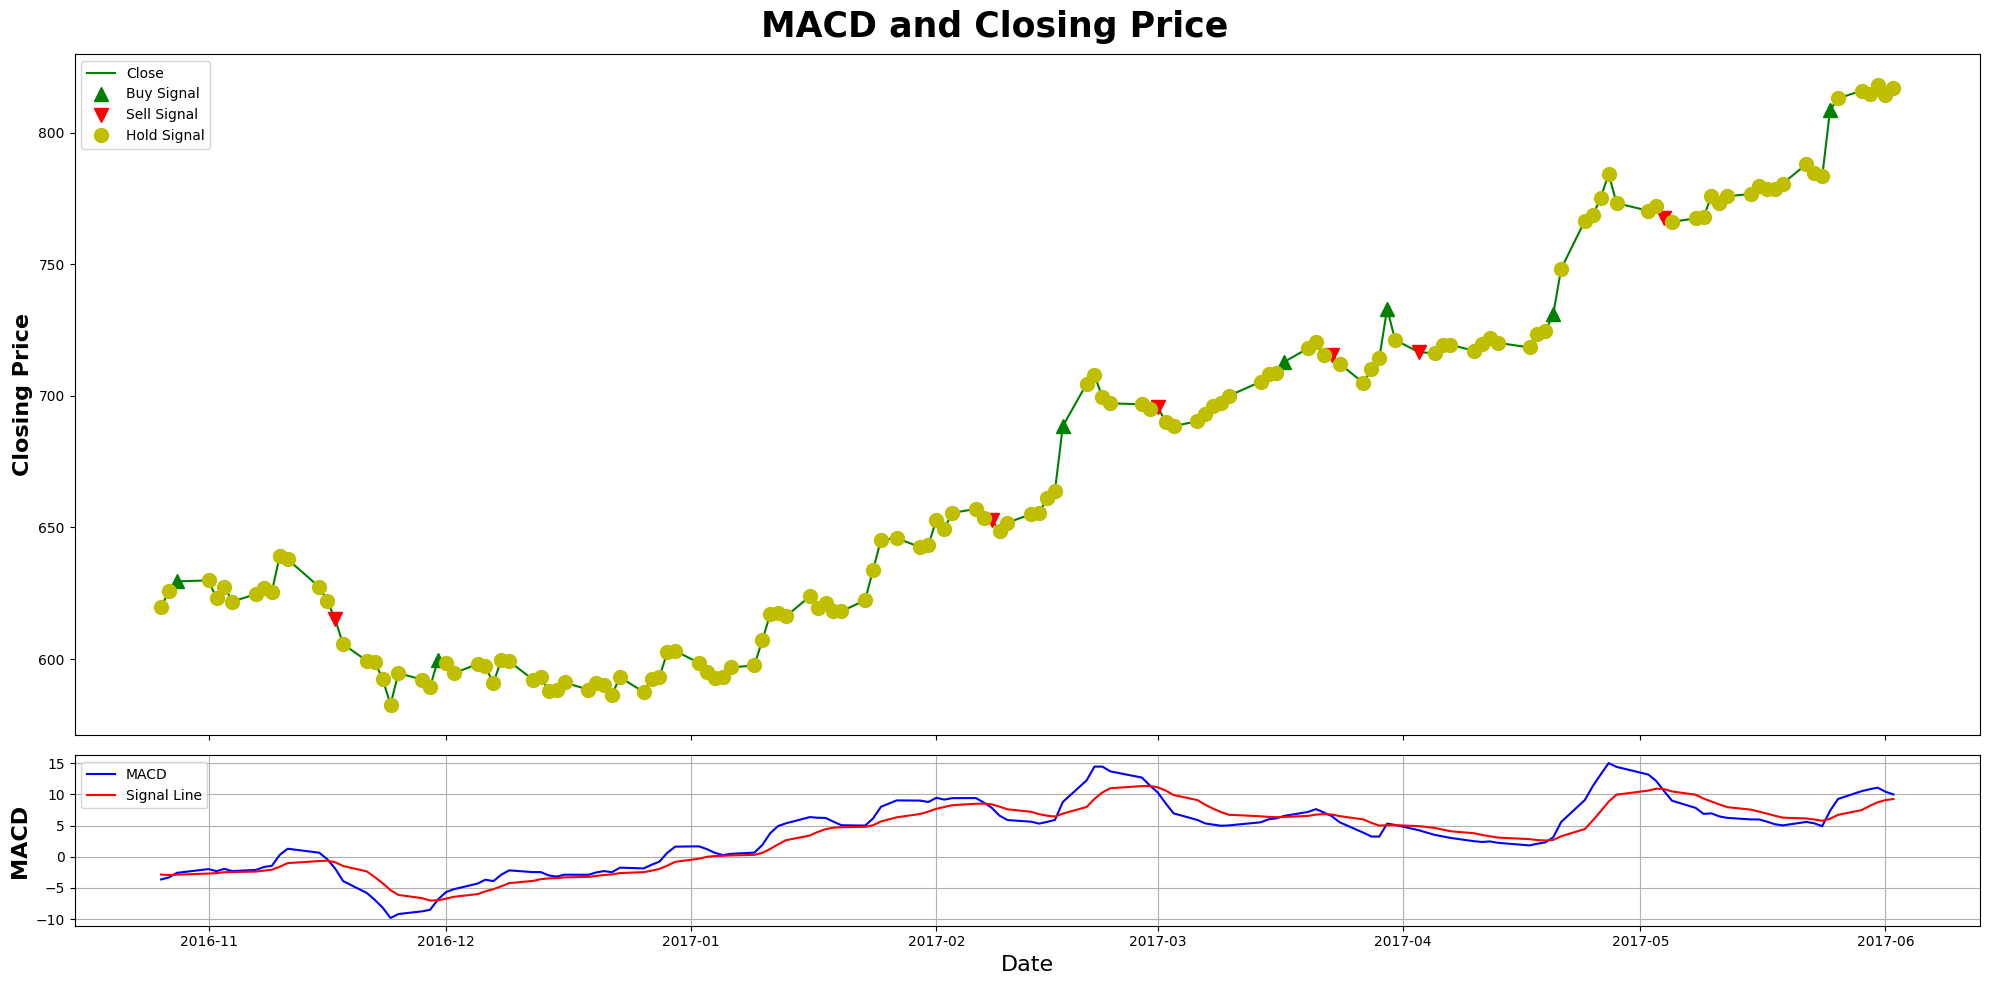

In [572]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

axs[0].plot(df.index, df['Close'], label='Close', color='green')
axs[0].set_ylabel('Closing Price',fontweight="bold", fontsize=16, fontfamily="sans-serif")

buy_signals = mac_sig[mac_sig==1].index
axs[0].plot(buy_signals, df.loc[buy_signals, "Close"], '^', markersize=10, color='green', lw=0, label='Buy Signal')

sell_signals = mac_sig[mac_sig==0].index
axs[0].plot(sell_signals, df.loc[sell_signals, "Close"], 'v', markersize=10, color='red', lw=0, label='Sell Signal')

hold_signals = mac_sig[mac_sig==2].index
axs[0].plot(hold_signals, df.loc[hold_signals, "Close"], 'o', markersize=10, color='y', lw=0, label='Hold Signal')

axs[0].legend()


axs[1].plot(mac.index, mac, label='MACD', color='blue')
axs[1].plot(mac.index, line, label='Signal Line', color='red')
axs[1].set_ylabel('MACD',fontweight="bold", fontsize=16, fontfamily="sans-serif")
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel('Date', fontsize=16, fontfamily="sans-serif")

fig.suptitle('MACD and Closing Price', fontsize=25, fontweight="bold", fontfamily="sans-serif")
plt.tight_layout()
plt.show()

**RSI Plot**

In [573]:
df=data[100:250]
rsi_check=rsi[100:250]

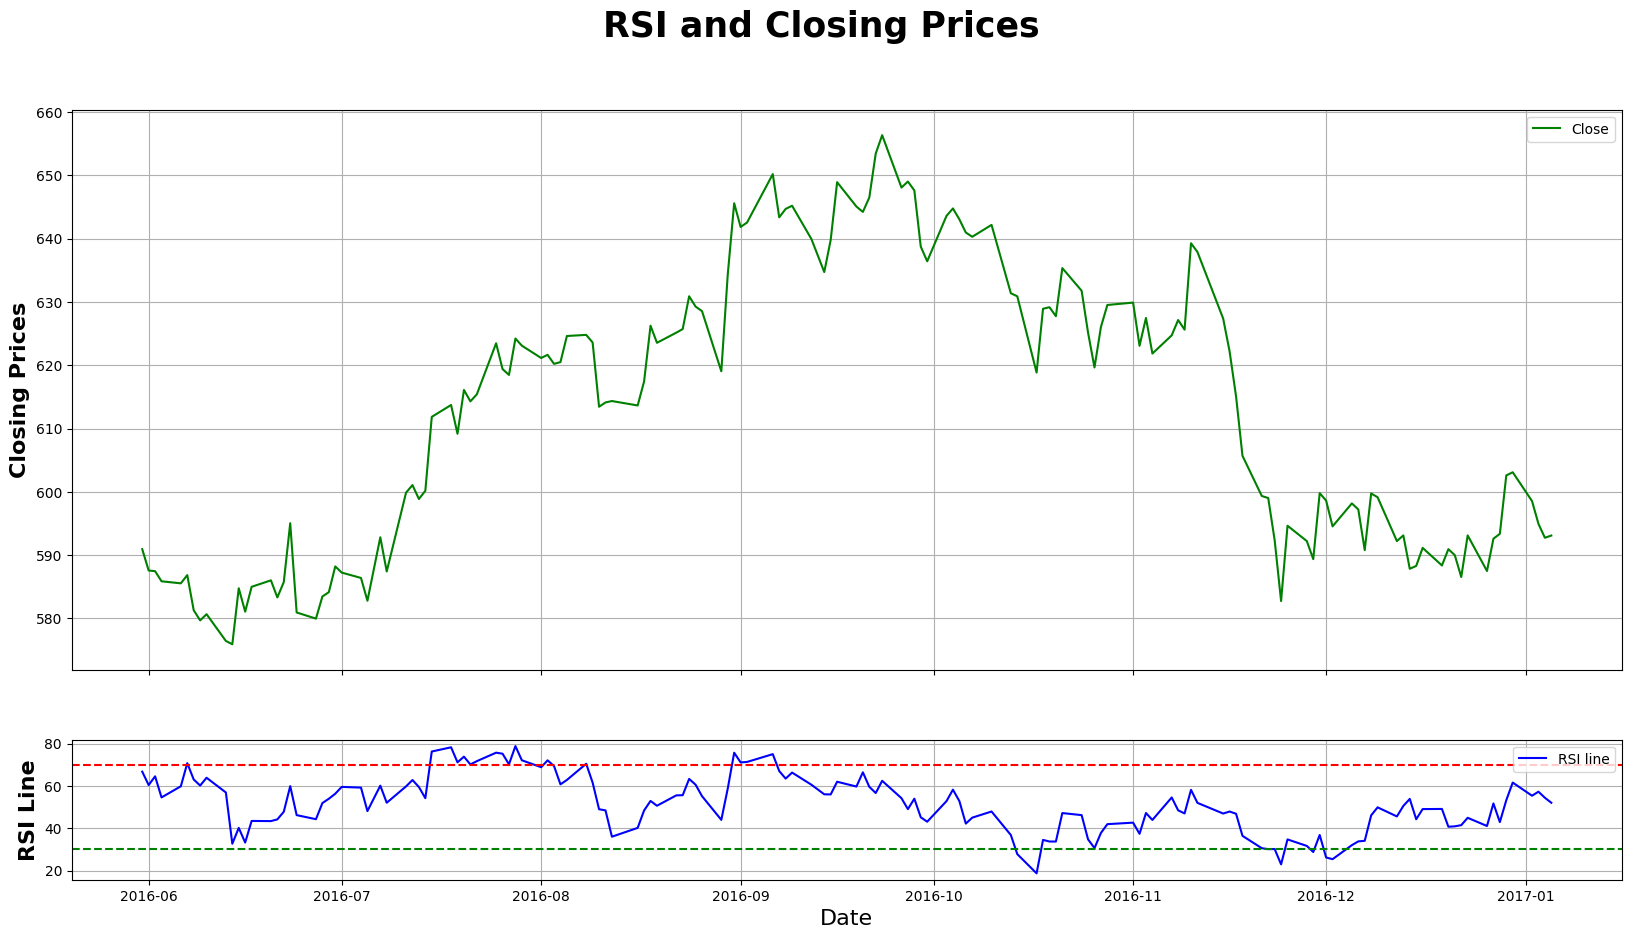

<Figure size 640x480 with 0 Axes>

In [574]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

axs[0].plot(df.index, df['Close'], label='Close', color='green')
axs[0].set_ylabel('Closing Prices',fontweight="bold", fontsize=16, fontfamily="sans-serif")
axs[0].grid(True)
axs[0].legend()


axs[1].plot(rsi_check.index, rsi_check, color='blue', label='RSI line')
axs[1].axhline(70, linestyle='--', color='red')
axs[1].axhline(30, linestyle='--', color='green')
axs[1].set_ylabel('RSI Line',fontweight="bold", fontsize=16, fontfamily="sans-serif")
axs[1].set_xlabel('Date', fontsize=16, fontfamily="sans-serif")
axs[1].legend(loc="upper right")
axs[1].grid(True)

fig.suptitle('RSI and Closing Prices', fontsize=25, fontweight="bold", fontfamily="sans-serif")
plt.show()
plt.tight_layout()

**ADX Line**

In [575]:
df=data[100:250]
adx_check=adx[100:250]

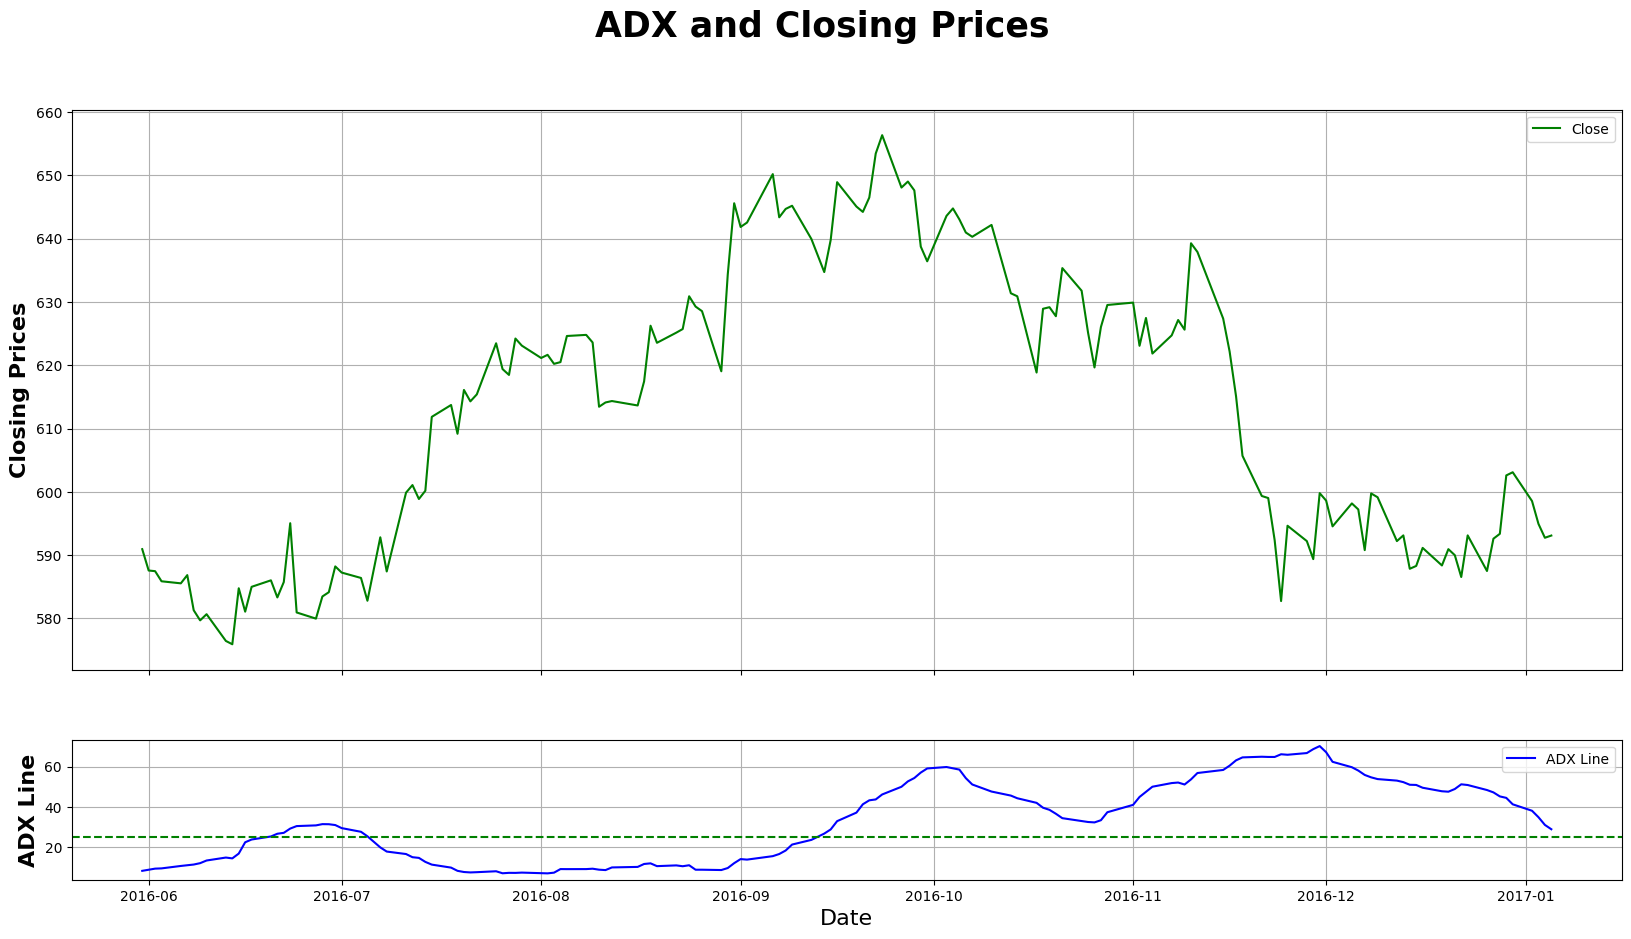

In [576]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

axs[0].plot(df.index, df['Close'], label='Close', color='green')
axs[0].set_ylabel('Closing Prices',fontweight="bold", fontsize=16, fontfamily="sans-serif")
axs[0].grid(True)
axs[0].legend()


axs[1].plot(adx_check.index, adx_check, color='blue', label='ADX Line')
axs[1].axhline(25, linestyle='--', color='green')
axs[1].set_ylabel('ADX Line',fontweight="bold", fontsize=16, fontfamily="sans-serif")
axs[1].set_xlabel('Date', fontsize=16, fontfamily="sans-serif")
axs[1].grid(True)
axs[1].legend()

fig.suptitle('ADX and Closing Prices', fontsize=25, fontweight="bold", fontfamily="sans-serif")
plt.show()

In [577]:
df=data[100:250]
ad_check=ad[100:250]

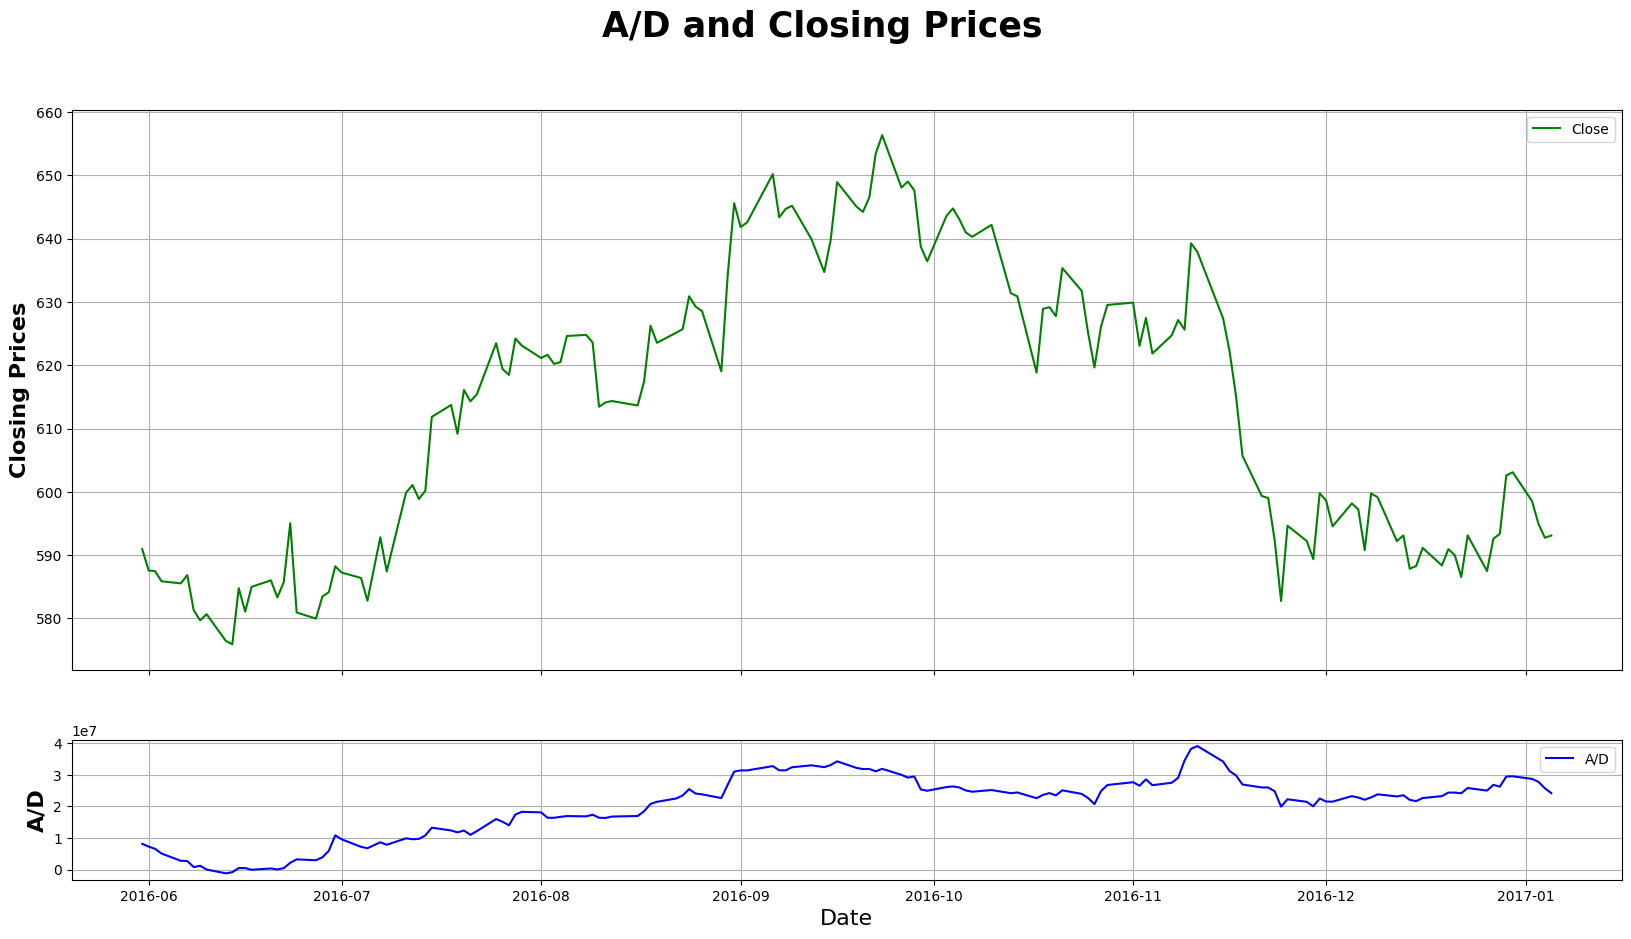

In [578]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

axs[0].plot(df.index, df['Close'], label='Close', color='green')
axs[0].set_ylabel('Closing Prices',fontweight="bold", fontsize=16, fontfamily="sans-serif")
axs[0].grid(True)
axs[0].legend()


axs[1].plot(ad_check.index, ad_check, color='blue', label='A/D')
axs[1].set_ylabel('A/D',fontweight="bold", fontsize=16, fontfamily="sans-serif")
axs[1].set_xlabel('Date', fontsize=16, fontfamily="sans-serif")
axs[1].grid(True)
axs[1].legend()

fig.suptitle('A/D and Closing Prices', fontsize=25, fontweight="bold", fontfamily="sans-serif")
plt.show()

**Bollinger Bands Signals**

In [579]:
bollinger_signals=generate_bollinger_band_signals(data["Close"],20)

In [580]:
df=data[100:250]
boll_sig=bollinger_signals[100:250]
boll_upper_check=upper_band[100:250]
boll_lower_check=lower_band[100:250]

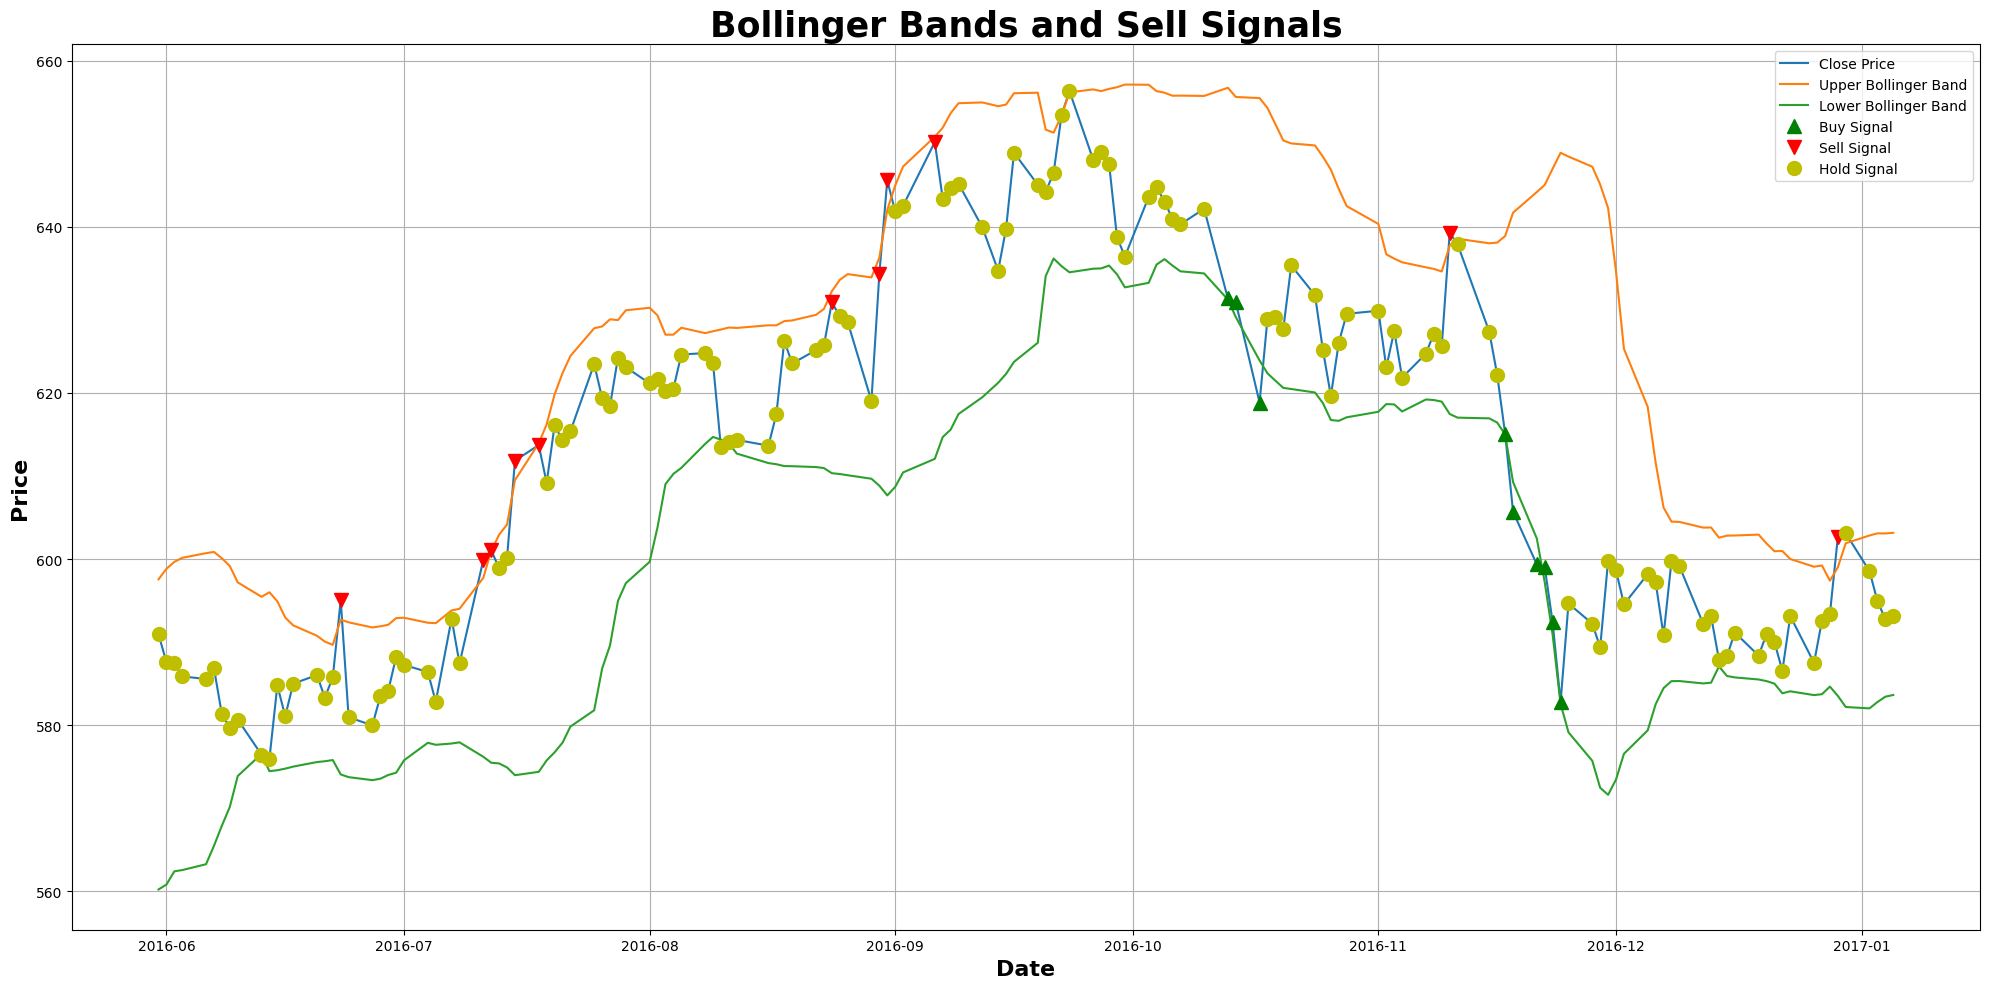

In [581]:
plt.figure(figsize=(20,10))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(boll_upper_check.index, boll_upper_check, label='Upper Bollinger Band')
plt.plot(boll_lower_check.index, boll_lower_check, label='Lower Bollinger Band')

buy_signals = boll_sig[boll_sig == 1].index
plt.plot(buy_signals, df.loc[buy_signals, "Close"], '^', markersize=10, color='g', lw=0, label='Buy Signal')

sell_signals = boll_sig[boll_sig == 0].index
plt.plot(sell_signals, df.loc[sell_signals, "Close"], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

hold_signals = boll_sig[boll_sig == 2].index
plt.plot(hold_signals, df.loc[hold_signals, "Close"], 'o', markersize=10, color='y', lw=0, label='Hold Signal')



plt.title('Bollinger Bands and Sell Signals',fontweight="bold", fontsize=25, fontfamily="sans-serif")
plt.xlabel('Date',fontweight="bold", fontsize=16, fontfamily="sans-serif")
plt.ylabel('Price',fontweight="bold", fontsize=16, fontfamily="sans-serif")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [582]:
ema_signals= generate_ema_crossover_signals(data["Close"], ema_fast, ema_slow)

In [583]:
df=data[100:500]
ema_sig=ema_signals[100:500]
ema_fast_check=ema_fast[100:500]
ema_slow_check=ema_slow[100:500]

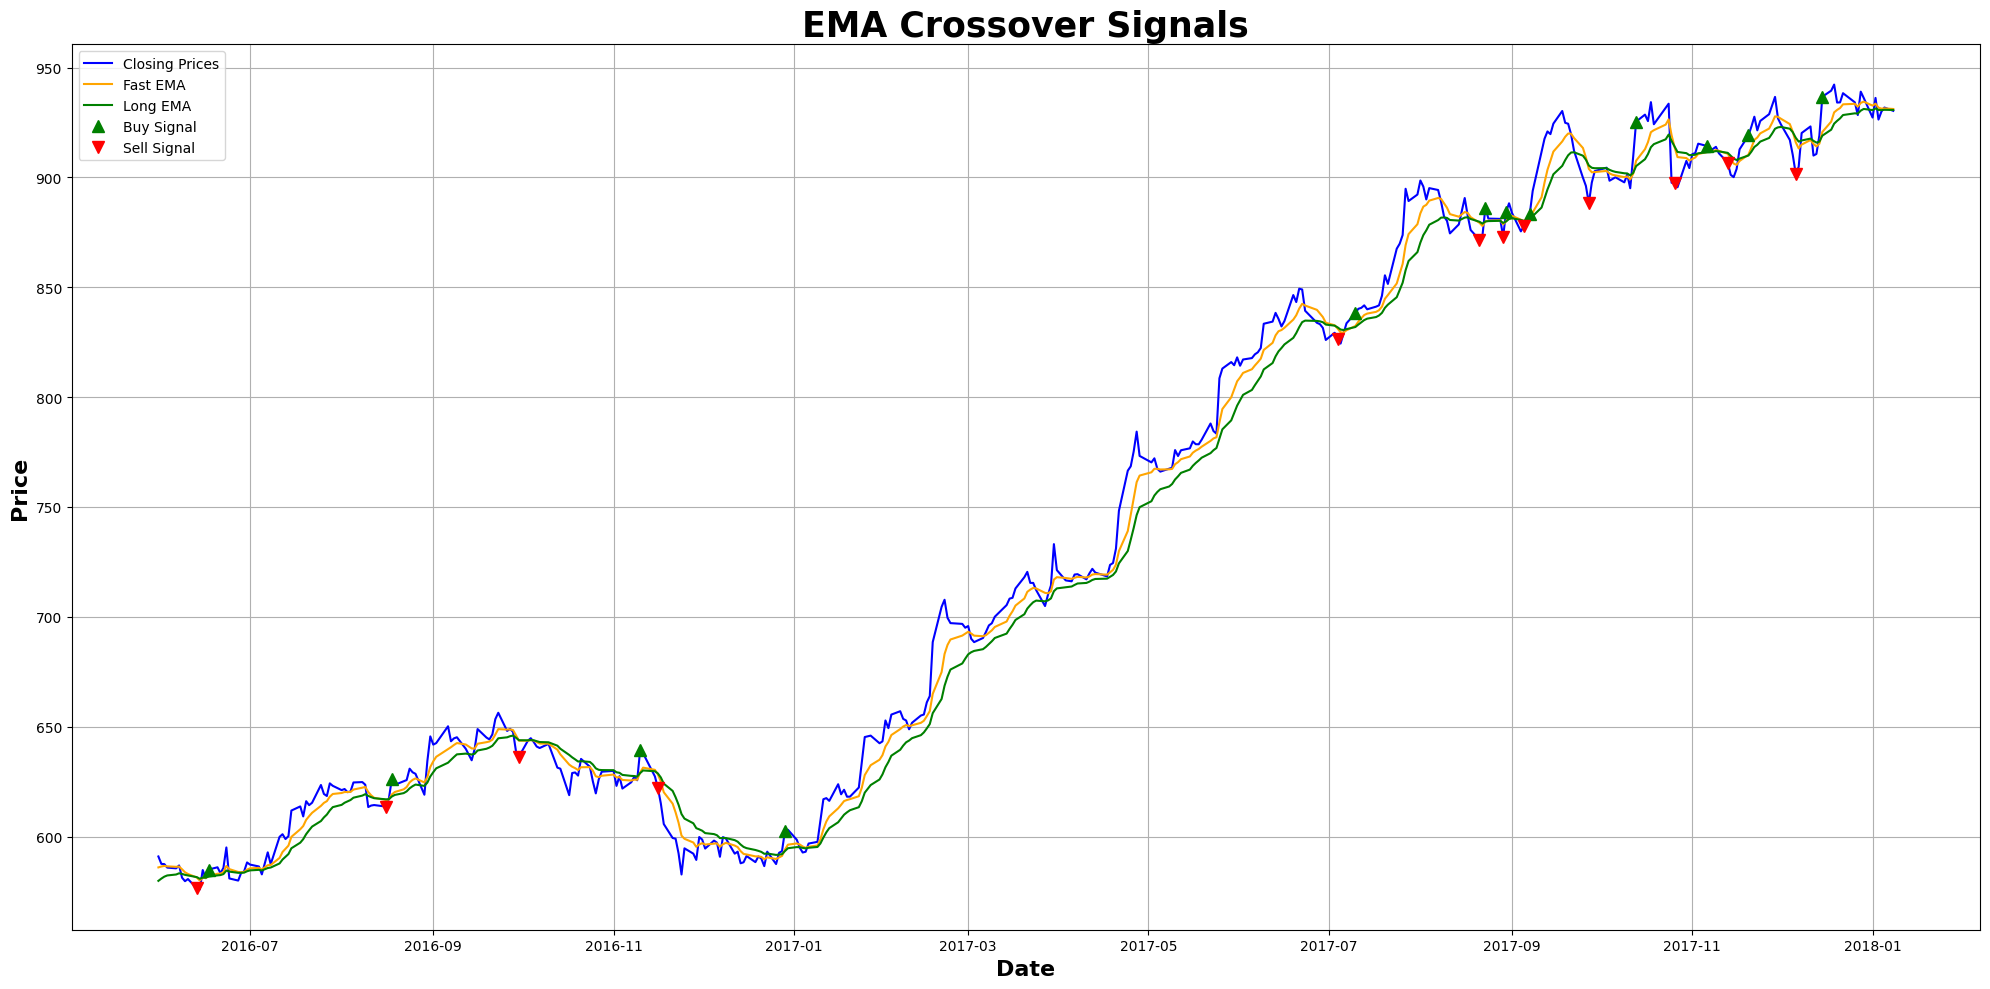

In [584]:
plt.figure(figsize=(20,10))

plt.plot(df["Close"], label='Closing Prices', color='blue')
plt.plot(ema_fast_check, label='Fast EMA', color='orange')
plt.plot(ema_slow_check, label='Long EMA', color='green')

plt.plot(df["Close"][ema_sig == 1], '^', markersize=8, color='g', label='Buy Signal')

plt.plot(df["Close"][ema_sig == 0], 'v', markersize=8, color='r', label='Sell Signal')

plt.title('EMA Crossover Signals',fontweight="bold", fontsize=25, fontfamily="sans-serif")
plt.xlabel('Date',fontweight="bold", fontsize=16, fontfamily="sans-serif")
plt.ylabel('Price',fontweight="bold", fontsize=16, fontfamily="sans-serif")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Label**

In [585]:
signal=buy_sell_prediction(data["Close"])

In [586]:
df=data[100:200]
signal_check=signal[100:200]

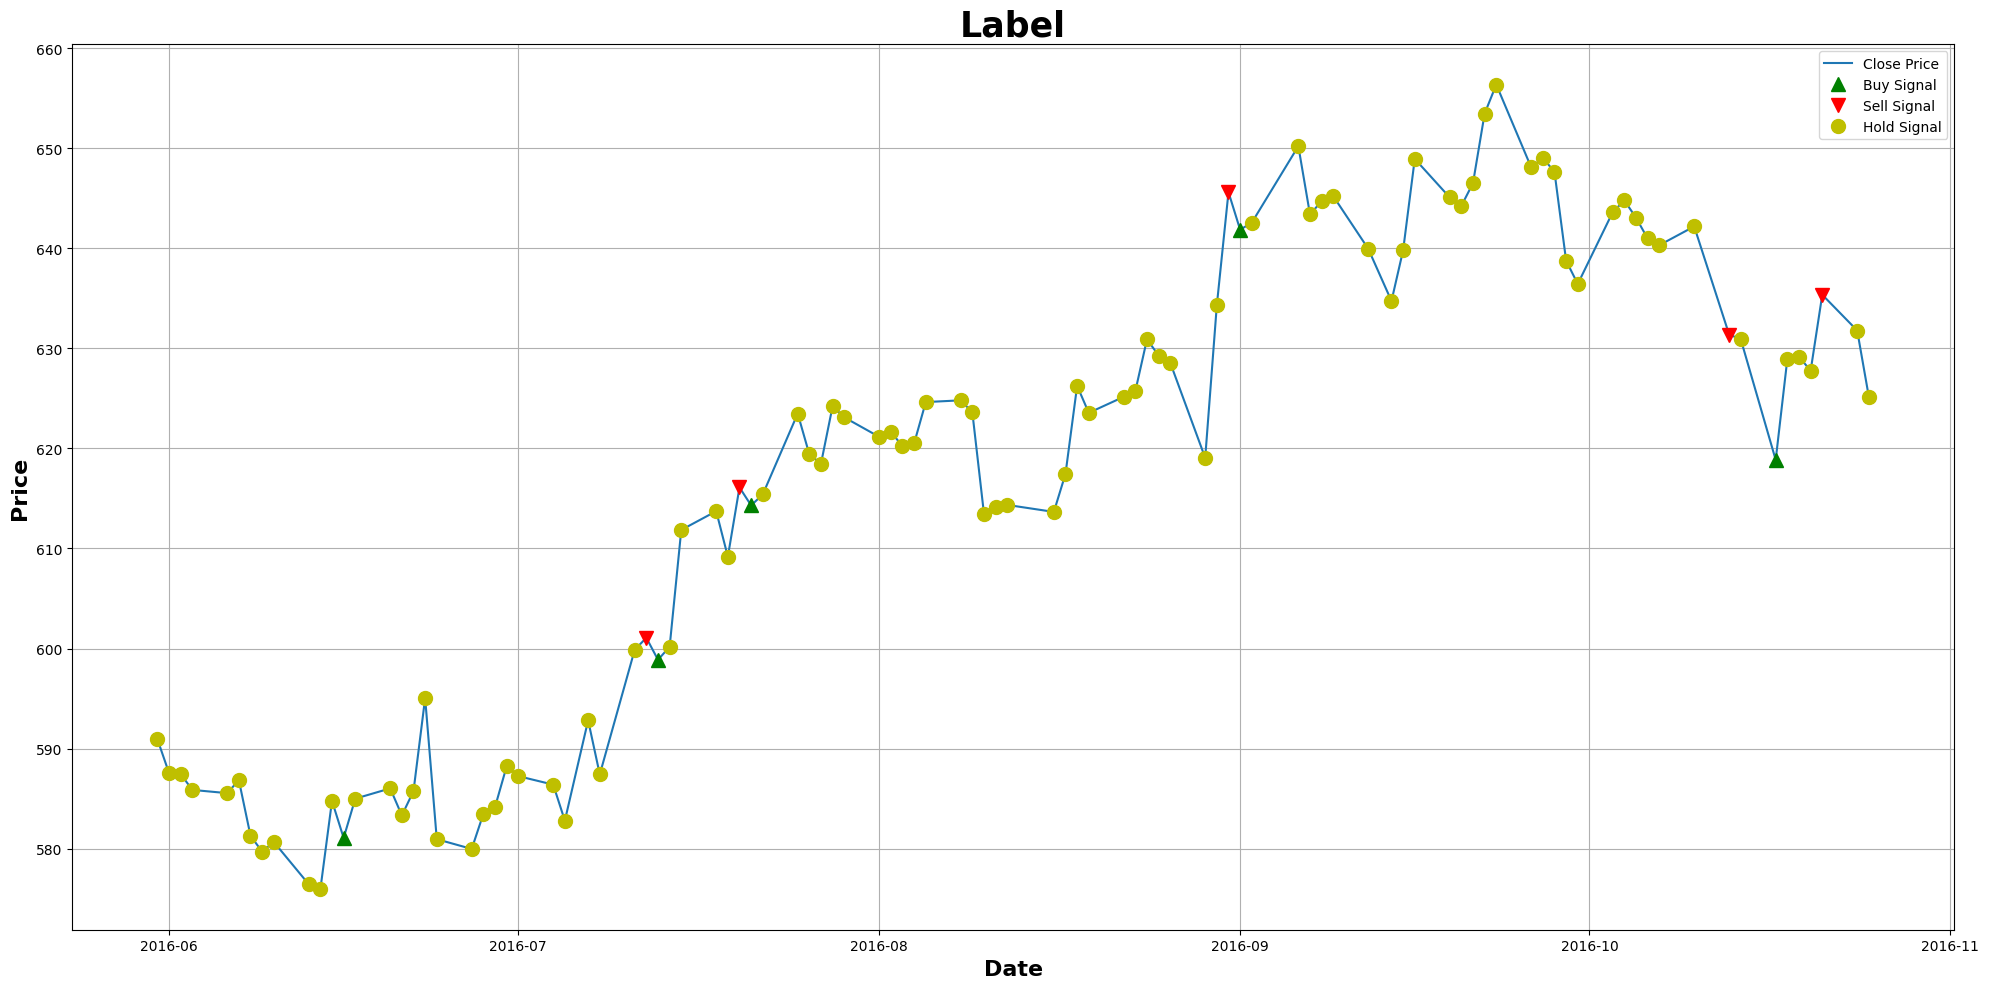

In [587]:
plt.figure(figsize=(20,10))

plt.plot(df.index, df['Close'], label='Close Price')

buy_signals = signal_check[signal_check == 1].index
plt.plot(buy_signals, df.loc[buy_signals, "Close"], '^', markersize=10, color='g', lw=0, label='Buy Signal')

sell_signals = signal_check[signal_check == 0].index
plt.plot(sell_signals, df.loc[sell_signals, "Close"], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

hold_signals = signal_check[signal_check == 2].index
plt.plot(hold_signals, df.loc[hold_signals, "Close"], 'o', markersize=10, color='y', lw=0, label='Hold Signal')



plt.title('Label',fontweight="bold", fontsize=25, fontfamily="sans-serif")
plt.xlabel('Date',fontweight="bold", fontsize=16, fontfamily="sans-serif")
plt.ylabel('Price',fontweight="bold", fontsize=16, fontfamily="sans-serif")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Data Preprocessing for feeding into the model**

In [588]:
data["A/D"]=ad
data["rsi"]=rsi
data["ADX"]=adx
data["macd"]=macd-macd_line
data["lower_band"]=lower_band
data["upper_band"]=upper_band
data["ema_crossovers"]=ema_fast-ema_slow
data["feature_1"]=feature_1
data["feature_2"]=feature_2
data["Signal"]=signal

In [589]:
data_copy=data.copy()
data_copy.dropna(axis=0,inplace=True)

In [590]:
data_copy.head()

,Open,High,Low,Close,Adj Close,Volume,A/D,rsi,ADX,macd,lower_band,upper_band,ema_crossovers,feature_1,feature_2,Signal
Date,,,,,,,,,,,,,,,,
2016-02-12,489.500000,493.225006,483.000000,485.700012,458.851685,6271072,-2.155145e+07,31.536057,36.443175,-4.067668,489.137034,542.416537,-7.943151,142.225955,-1.157887e+06,2.0
2016-02-15,490.000000,494.125000,485.549988,486.799988,459.890839,5456480,-2.541712e+07,27.610207,34.421913,-3.973736,483.037413,543.691155,-8.842652,125.888634,-1.221695e+06,2.0
2016-02-16,490.750000,491.000000,481.000000,486.725006,459.820007,3568048,-2.489975e+07,28.625434,32.780581,-3.417924,478.021074,544.264636,-9.141321,101.534329,-7.626548e+05,1.0
2016-02-17,488.450012,489.950012,479.500000,487.450012,460.504944,3751962,-2.294298e+07,30.139886,31.139248,-2.578211,473.976736,544.251836,-8.946161,69.899580,-7.451439e+05,2.0
2016-02-18,493.000000,495.625000,488.500000,494.725006,467.377808,3399928,-2.040198e+07,28.335732,31.711477,-1.043522,472.261762,541.652527,-7.672353,19.364512,-7.365695e+05,2.0


In [591]:
y=data_copy.Signal
data_copy.drop("Signal", axis=1, inplace=True)

In [592]:
data_copy.drop("Open", axis=1, inplace=True)
data_copy.drop("High", axis=1, inplace=True)
data_copy.drop("Low", axis=1, inplace=True)
data_copy.drop("Adj Close", axis=1, inplace=True)
data_copy.drop("Close", axis=1, inplace=True)
data_copy.drop("Volume", axis=1, inplace=True)

In [593]:
data_copy.head()

,A/D,rsi,ADX,macd,lower_band,upper_band,ema_crossovers,feature_1,feature_2
Date,,,,,,,,,
2016-02-12,-2.155145e+07,31.536057,36.443175,-4.067668,489.137034,542.416537,-7.943151,142.225955,-1.157887e+06
2016-02-15,-2.541712e+07,27.610207,34.421913,-3.973736,483.037413,543.691155,-8.842652,125.888634,-1.221695e+06
2016-02-16,-2.489975e+07,28.625434,32.780581,-3.417924,478.021074,544.264636,-9.141321,101.534329,-7.626548e+05
2016-02-17,-2.294298e+07,30.139886,31.139248,-2.578211,473.976736,544.251836,-8.946161,69.899580,-7.451439e+05
2016-02-18,-2.040198e+07,28.335732,31.711477,-1.043522,472.261762,541.652527,-7.672353,19.364512,-7.365695e+05


# **Training the Model**

In [594]:

#Splitting the dataset
X_train = data_copy[:784]
y_train = y[:784]
X_test = data_copy[784:]
y_test = y[784:]

#Normaliising the set of data
np.random.seed(44)
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
data_copy_scaled=scaler.transform(data_copy)
num_classes = len(set(y_train))


#One hot encoding
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
y_encoded= tf.keras.utils.to_categorical(y, num_classes=num_classes)

#Model Fitting and predictions
w_pred, b_pred = train(X_train_scaled, y_train_encoded, epochs=100, learning_rate=0.001)

y_pred = forward_prop(X_test_scaled, w_pred, b_pred)
test_loss = categorical_cross_entropy_loss(y_pred, y_test_encoded)
accuracy = np.mean(np.argmax(y_pred, axis=1) == y_test)

#Calculating the scores
roc_auc = roc_auc_score(np.argmax(y_test_encoded, axis=1), y_pred, multi_class='ovr')
f1 = f1_score(np.argmax(y_test_encoded, axis=1),np.argmax(y_pred, axis=1), average='weighted')

print()
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.4f}%')
print(f'F1 score: {f1*100:.4f}%')
print(f'ROC-AUC score: {roc_auc*100:.4f}%')

Epoch 1/100, Loss: 1.0964
Epoch 2/100, Loss: 1.0960
Epoch 3/100, Loss: 1.0956
Epoch 4/100, Loss: 1.0952
Epoch 5/100, Loss: 1.0948
Epoch 6/100, Loss: 1.0944
Epoch 7/100, Loss: 1.0939
Epoch 8/100, Loss: 1.0935
Epoch 9/100, Loss: 1.0931
Epoch 10/100, Loss: 1.0927
Epoch 11/100, Loss: 1.0923
Epoch 12/100, Loss: 1.0919
Epoch 13/100, Loss: 1.0914
Epoch 14/100, Loss: 1.0910
Epoch 15/100, Loss: 1.0906
Epoch 16/100, Loss: 1.0902
Epoch 17/100, Loss: 1.0898
Epoch 18/100, Loss: 1.0894
Epoch 19/100, Loss: 1.0889
Epoch 20/100, Loss: 1.0885
Epoch 21/100, Loss: 1.0881
Epoch 22/100, Loss: 1.0877
Epoch 23/100, Loss: 1.0873
Epoch 24/100, Loss: 1.0869
Epoch 25/100, Loss: 1.0865
Epoch 26/100, Loss: 1.0861
Epoch 27/100, Loss: 1.0856
Epoch 28/100, Loss: 1.0852
Epoch 29/100, Loss: 1.0848
Epoch 30/100, Loss: 1.0844
Epoch 31/100, Loss: 1.0840
Epoch 32/100, Loss: 1.0836
Epoch 33/100, Loss: 1.0832
Epoch 34/100, Loss: 1.0828
Epoch 35/100, Loss: 1.0824
Epoch 36/100, Loss: 1.0819
Epoch 37/100, Loss: 1.0815
Epoch 38/1